In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import time
from statistics import mean

import math
import sys

In [2]:
DATASET_PATH = "/kaggle/input/coco-2017-dataset/coco2017"
TRAIN_IMAGES = f"{DATASET_PATH}/train2017"
VAL_IMAGES = f"{DATASET_PATH}/val2017"
TRAIN_ANN = f"{DATASET_PATH}/annotations/instances_train2017.json"
VAL_ANN = f"{DATASET_PATH}/annotations/instances_val2017.json"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_dataset = CocoDetection(root=TRAIN_IMAGES, annFile=TRAIN_ANN, transform=transform)
val_dataset = CocoDetection(root=VAL_IMAGES, annFile=VAL_ANN, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=18.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


In [5]:
cocoObjTrain=train_dataset.coco

In [6]:
"Prove per capire come funziona il dataloader dimensionalmente"
print("Dimensione del dataset di train: ", len(train_dataset))
print("Dimensione del dataset di validation : ",len(val_dataset))

num_annotations = 2

img,annotations = next(iter(train_dataset))

print(img.shape)
print(type(img))
print(len(annotations))
#per il nostro task ci interessano BB e CLASSIFICAZIONE
preds= annotations[num_annotations]['bbox']
print("bbox: ",preds)
#come prendere info sulla classe associata al bbox
id_classe = annotations[num_annotations]['category_id']
class_name=cocoObjTrain.cats[id_classe]['name']
print(cocoObjTrain.cats[id_classe]['name'])

Dimensione del dataset di train:  118287
Dimensione del dataset di validation :  5000
torch.Size([3, 480, 640])
<class 'torch.Tensor'>
8
bbox:  [249.6, 229.27, 316.24, 245.08]
broccoli


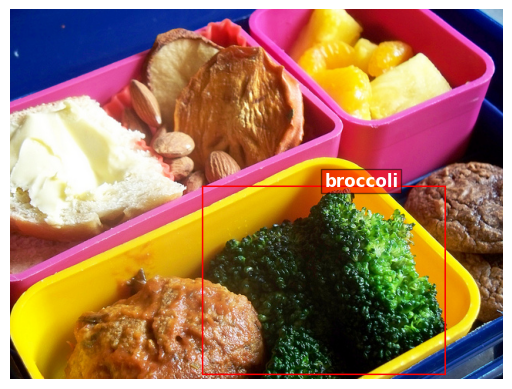

In [7]:
"plot dell'immagine per verifica visiva"
from PIL import ImageDraw
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import ImageFont

test_image = transforms.ToPILImage()(img)
draw = ImageDraw.Draw(test_image)

##rectangle vuoe (x,y,x,y)
x, y, w, h = preds
right_boxes=[x,y,x+w,y+h]
x_middle = (x+(x+w))/2

draw.rectangle(right_boxes, outline="red", width=2)

font = ImageFont.load_default()
plt.text(x_middle,y, class_name, color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='red', alpha=0.5, pad=2))

plt.imshow(test_image)
plt.axis("off")
plt.show()

**OSSERVAZIONI**
dalle ultime due celle si capice che
* il dataloader ritorna un oggetto di tipo Dataset,rendendolo iterable è possibile ottenere la singola coppia (img,ann)
* le img sono rgb di dim diverse
* ann è una lista di annotations poichè ogni immagine ha più label
* dell'elemento i-esimo della lista ann ci interessa i valori associati ale chiavi 'bbox' e 'category_id' che ci permettono di accedere alle bbox e alla classe predetta a quel bbox
* #IMPORTANE#  si nota che il formato di bbox non è compatibile con quello voluto da pytorch, per la conversione basta applicare la seuente formula (right_boxes=[x,y,x+w,y+h])

In [8]:
"RIDUZIONE DATASET PER TRAINING PIù VELOCE"
import math
from torch.utils.data import Subset

# Reduce dataset size for faster training
subset_size = 4000 # Try 1000–3000 depending on time
indices = torch.randperm(len(train_dataset))[:subset_size].tolist()
train_subset = Subset(train_dataset, indices)

train_loader = DataLoader(
    train_subset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)

steps_per_epoch = math.ceil(len(train_subset) / train_loader.batch_size)
print(f"✅ Using {len(train_subset)} images → {steps_per_epoch} steps per epoch")


val_subset_size = 1000   
val_indices = list(range(val_subset_size))
val_subset = Subset(val_dataset, val_indices)

val_loader = DataLoader(
    val_subset,
    batch_size=4,
    shuffle=False,     # Shuffle NO per la validazione (vogliamo stabilità)
    num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)
val_steps = len(val_loader)
print(f"✅ VAL:   Using {len(val_subset)} images (First {len(val_subset)}) → {val_steps} steps")

✅ Using 4000 images → 1000 steps per epoch
✅ VAL:   Using 1000 images (First 1000) → 250 steps


In [9]:
def get_model(num_classes):
    # Load pretrained Faster R-CNN model (ResNet50 backbone)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    
    # Get input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace with new head (COCO has 91 classes)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

num_classes = 91  # COCO has 80 classes + background + reserved ids
model = get_model(num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 242MB/s]


In [10]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

In [12]:
"il modello vuole in ingresso un dizionario!!!"
def coco_to_fasterrcnn_targets(anns, device):
    boxes, labels = [], []
    for obj in anns:
        x, y, w, h = obj['bbox']
        if w > 0 and h > 0:  # Only valid boxes
            boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
            labels.append(obj['category_id'])
    return {
        'boxes': torch.as_tensor(boxes, dtype=torch.float32, device=device),
        'labels': torch.as_tensor(labels, dtype=torch.int64, device=device)
    }

In [13]:
def train_one_epoch(model, optimizer, data_loader, device, epoch,num_epochs,lr_scheduler):
    print(f"\nStarting Epoch [{epoch+1}/{num_epochs}] ...")
    
    step_times = []
    start = time.time()
    
    #variabili per memorizzare andamnento delle loss
    epoch_loss_breakdown = {} #uso il dizionario per poter salvare l'andamento di tutte le Loss
    avg_loss=0.0
    acc_loss=0.0 #varibile dove accumulo la somma di tutte le loss
    
    for i, (imgs, annotations) in enumerate(data_loader, 1):
        t0 = time.time()

        # muoviti immagini e ann nella GPU
        imgs = [img.to(device) for img in imgs]
        targets = [coco_to_fasterrcnn_targets(a, device) for a in annotations]

        #salta se non ha ann
        if any(len(t["boxes"]) == 0 for t in targets):
            continue

        # Forward + backward
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
     
        # Log progress ogni 100 step
        step_times.append(time.time() - t0)
        if i % 30 == 0:
            avg_time = mean(step_times[-20:])
            eta = (steps_per_epoch - i) * avg_time
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}/{steps_per_epoch}] "
                  f"Loss: {losses.item():.4f} | ETA: {eta/60:.1f} min")

        #accumulo la somma delle loss
        acc_loss += losses.item()
        
        #accumulo le loss per ogni step
        for k, v in loss_dict.items():
            if k not in epoch_loss_breakdown:
                epoch_loss_breakdown[k] = 0.0 # Inizializziamo se è la prima volta
            epoch_loss_breakdown[k] += v.item()
            
            
    lr_scheduler.step()
    avg_loss = acc_loss / len(data_loader)
    print(f"✅ Epoch [{epoch+1}] done in {(time.time()-start)/60:.2f} min with Loss {avg_loss}")

    #calcolo loss media, per ogni loss
    avg_loss_dict = {}
    for k, v in epoch_loss_breakdown.items():
        avg_loss_dict[k] = v / len(data_loader)
    avg_loss_dict["avg_loss_epoch"]=avg_loss
    
    return avg_loss_dict

In [14]:
@torch.no_grad()
def evaluate_loss(model,data_loader, device):
    print(f"\nInizio Validazione...")
    val_loss = 0.0
    
    # Setup per il log
    steps_per_epoch_val = len(data_loader)
    step_times = []
    start_time = time.time()
    
    for i, (imgs, annotations) in enumerate(data_loader, 1):
        t0 = time.time()
        images = list(image.to(device) for image in imgs)
        targets = [coco_to_fasterrcnn_targets(a, device) for a in annotations]

        if any(len(t["boxes"]) == 0 for t in targets):
            continue

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        step_times.append(time.time() - t0)
        
        if i % 10 == 0:
            avg_time = sum(step_times[-20:]) / 20
            eta = (steps_per_epoch_val - i) * avg_time
            print(f"Val Step [{i}/{steps_per_epoch_val}] "
                  f"Loss: {losses.item():.4f} | ETA: {eta/60:.1f} min")  

        val_loss += losses.item()
        
    validation_loss = val_loss/ len(data_loader) 
    print(f"✅ Epoch [{epoch+1}] done with Loss {validation_loss}")
    return validation_loss

In [15]:
history_train={}
val_loss_history=[]

def update_history(history_of_epoch,avg_val_loss,model):
    #salvo
    for k, v in history_of_epoch.items():
        if k not in history_train:
            history_train[k] = []
        history_train[k].append(v)
        
    val_loss_history.append(avg_val_loss)

    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'train_loss_history_detailed': history_train,
        'val_loss_history_detailed': val_loss_history
    }, "fasterrcnn_detailed.pth")

In [16]:
print(len(history_train))

0


In [17]:
num_epochs=20

model.train()

for epoch in range (num_epochs):
    history_of_epoch = train_one_epoch(model, optimizer, train_loader, device,epoch,num_epochs, lr_scheduler)

    avg_val_loss = evaluate_loss(model, val_loader, device)

    update_history(history_of_epoch,avg_val_loss,model)


Starting Epoch [1/20] ...
Epoch [1/20] Step [30/1000] Loss: 1.7170 | ETA: 4.8 min
Epoch [1/20] Step [60/1000] Loss: 1.2128 | ETA: 4.9 min
Epoch [1/20] Step [90/1000] Loss: 1.3191 | ETA: 4.6 min
Epoch [1/20] Step [120/1000] Loss: 0.5982 | ETA: 4.8 min
Epoch [1/20] Step [150/1000] Loss: 0.6990 | ETA: 4.6 min
Epoch [1/20] Step [180/1000] Loss: 0.7348 | ETA: 4.3 min
Epoch [1/20] Step [210/1000] Loss: 0.8128 | ETA: 4.3 min
Epoch [1/20] Step [240/1000] Loss: 0.9414 | ETA: 4.0 min
Epoch [1/20] Step [270/1000] Loss: 0.8957 | ETA: 3.7 min
Epoch [1/20] Step [300/1000] Loss: 0.8700 | ETA: 3.5 min
Epoch [1/20] Step [330/1000] Loss: 0.5145 | ETA: 3.4 min
Epoch [1/20] Step [360/1000] Loss: 0.8498 | ETA: 3.5 min
Epoch [1/20] Step [390/1000] Loss: 0.8376 | ETA: 3.2 min
Epoch [1/20] Step [420/1000] Loss: 0.8616 | ETA: 3.1 min
Epoch [1/20] Step [450/1000] Loss: 0.7728 | ETA: 3.0 min
Epoch [1/20] Step [480/1000] Loss: 0.5331 | ETA: 2.8 min
Epoch [1/20] Step [510/1000] Loss: 1.0557 | ETA: 2.7 min
Epoch [

Caricamento file da: /kaggle/working/fasterrcnn_detailed.pth ...
File caricato correttamente! Training fermato all'epoca: 20


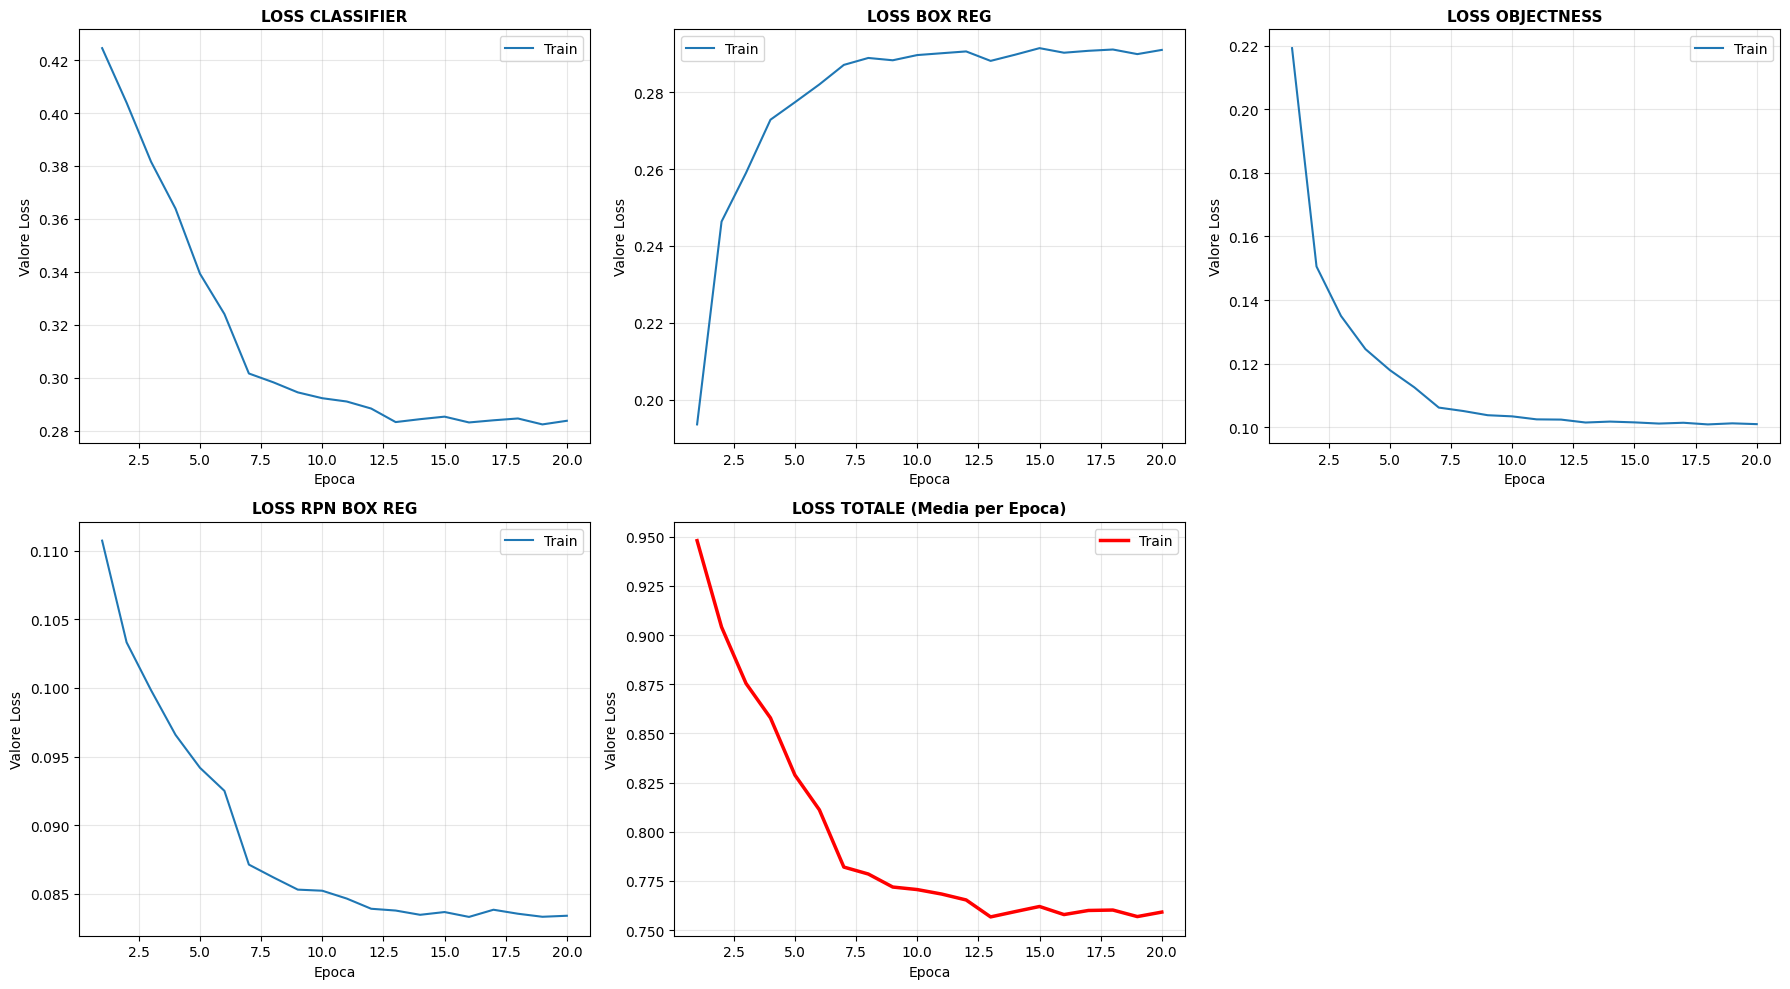

In [18]:
import torch
import matplotlib.pyplot as plt
import math
import os

# --- 1. CARICAMENTO DATI DAL FILE .PTH ---
file_path = "/kaggle/working/fasterrcnn_detailed.pth"

if not os.path.exists(file_path):
    print(f"ERRORE: Il file non esiste nel percorso: {file_path}")
else:
    print(f"Caricamento file da: {file_path} ...")
    # Usa map_location='cpu' per evitare errori se carichi su una macchina senza GPU
    checkpoint = torch.load(file_path, map_location='cpu')

    # Estrazione delle history dal dizionario salvato
    history_train = checkpoint['train_loss_history_detailed']
    val_loss_history = checkpoint['val_loss_history_detailed']
    epoch_saved = checkpoint['epoch']
    
    print(f"File caricato correttamente! Training fermato all'epoca: {epoch_saved}")

    # --- 2. PREPARAZIONE DATI ---
    keys = list(history_train.keys())
    num_plots = len(keys)
    
    # Calcolo epoche basato sulla lunghezza della history salvata
    num_epochs = len(val_loss_history)
    epoche = range(1, num_epochs + 1)

    # --- 3. IMPOSTAZIONE GRIGLIA ---
    cols = 3 
    rows = math.ceil(num_plots / cols)

    # Creazione figura
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten() 

    # --- 4. CICLO PLOTTING ---
    for i, key in enumerate(keys):
        ax = axes[i]
        
        # Stile personalizzato
        if key == "avg_loss_epoch":
            color = 'red'
            linewidth = 2.5
            title = "LOSS TOTALE (Media per Epoca)"
            
            # --- AGGIUNTA VALIDATION LOSS (Solo nel grafico totale) ---
            # È utilissimo vederle insieme per capire l'overfitting
            #if len(val_loss_history) > 0:
                #ax.plot(epoche, val_loss_history, label='Validation', color='green', linestyle='--', linewidth=2)
        else:
            color = 'tab:blue'
            linewidth = 1.5
            title = key.replace('_', ' ').upper() 
        
        # Plot Train Loss corrente
        ax.plot(epoche, history_train[key], label='Train', color=color, linewidth=linewidth)
        
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.set_xlabel('Epoca')
        ax.set_ylabel('Valore Loss')
        ax.grid(True, alpha=0.3)
        ax.legend()

    # --- 5. PULIZIA GRAFICI VUOTI ---
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

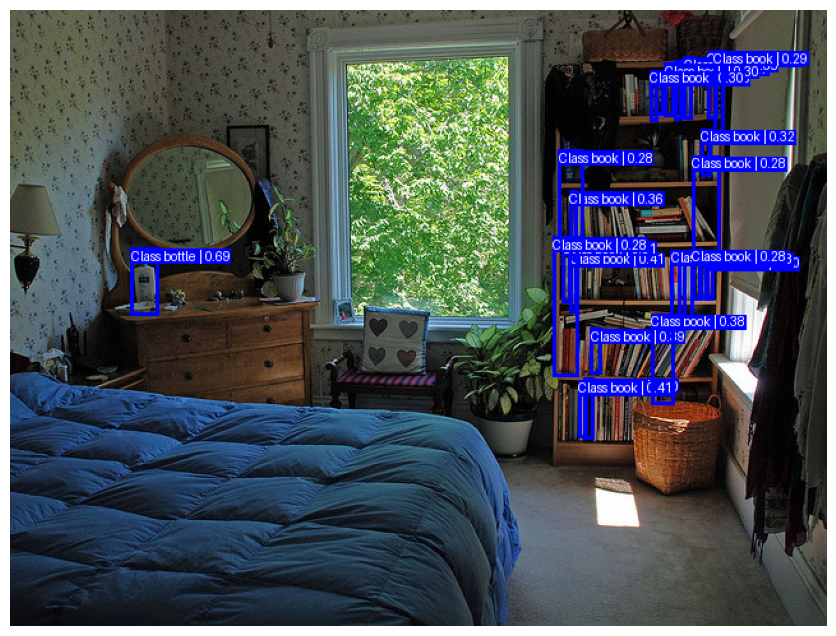

In [19]:
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import torchvision.ops as ops  # <--- Serve per la pulizia (NMS)

# 1. PREDIZIONE
images, targets = next(iter(val_loader)) 
img = images[2] 
model.eval() 
with torch.no_grad():
    prediction = model([img.to(device)])[0]

# --- PARTE NUOVA: PULIZIA (NMS) ---
# Tieni solo i box con confidenza > 0.5 (o alza a 0.7 se è ancora sporco)
score_threshold = 0.275
keep_indices = prediction['scores'] >= score_threshold

boxes = prediction['boxes'][keep_indices]
scores = prediction['scores'][keep_indices]
labels = prediction['labels'][keep_indices]

# Applica NMS: se due box si sovrappongono per più del 30% (0.3), tiene solo il migliore
# Abbassa 0.3 se vuoi eliminare PIÙ box sovrapposti
keep_nms = ops.nms(boxes, scores, iou_threshold=0.25)

# Filtriamo tutto usando gli indici rimasti dopo la NMS
final_boxes = boxes[keep_nms]
final_scores = scores[keep_nms]
final_labels = labels[keep_nms]
# ----------------------------------

# 2. DISEGNO
test_image = transforms.ToPILImage()(img.cpu())
draw = ImageDraw.Draw(test_image)

# Carica un font (opzionale, se dà errore usa quello di default)
try:
    font = ImageFont.truetype("arial.ttf", 15)
except:
    font = ImageFont.load_default()

for i in range(len(final_boxes)):
    box = final_boxes[i].cpu().numpy()
    score = final_scores[i].item()
    label = final_labels[i].item()
    
    # Colori diversi per classi diverse (opzionale, carino da vedere)
    color = "red" if label == 1 else "blue" # Esempio: persona rossa, altro blu
    
    draw.rectangle(box, outline=color, width=3)
    
    # Testo
    class_name=cocoObjTrain.cats[label]['name']
    text = f"Class {class_name} | {score:.2f}"
    
    # Sfondo del testo per renderlo leggibile
    text_bbox = draw.textbbox((box[0], box[1]), text, font=font)
    draw.rectangle(text_bbox, fill=color)
    draw.text((box[0], box[1]), text, fill="white", font=font)

plt.figure(figsize=(12, 8))
plt.imshow(test_image)
plt.axis("off")
plt.show()